[1.0000000000000044, 455.203322102761]
Min and max eigenvalues of A :  None
[1.0000000000000044, 455.203322102761]
Min and max eigenvalues of A :  None
[1.0000000000000044, 455.203322102761]
Min and max eigenvalues of A :  None


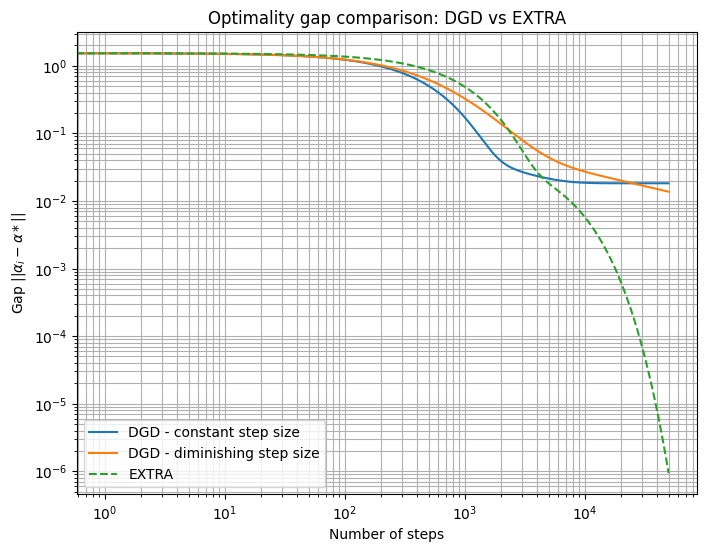

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import networkx as nx
from centralized_solution import *

from graph_tools import metropolis_weight_matrix, laplacian_weight_matrix
from kernel import kernel_matrix, grad_fi, calc_f

def solve_mod(x,y,x_selected):
    n = len(x)

    M = Cov2(x, x_selected)
    A = (0.5**2)*Cov(x_selected) + M.T @ M
    b = M.T @ y

    # here the regularization parameter nu is 1.0
    A = A + 1.*np.eye(int(np.sqrt(n)))

    # it is good to compute the max/min eigenvalues of A for later, but only for small-size matrices
    if n<101:
        ei, EI =np.linalg.eig(A)
        vv = [min(ei), max(ei)]
        print('Min and max eigenvalues of A : ', print(vv))

    alpha = np.linalg.solve(A,b)

    return alpha

def dgd(a,m,agents,Kmm, Knm,W,y, step_count, step_size, constant_step_size = True):
    xi = np.random.normal(0, 0.01, size=(step_count+1, a, m))
    g = np.zeros((a, m))
    # local gradients
    for i, id_agent in enumerate(agents):
        g[i, :] = grad_fi(y, Kmm, Knm, xi[0,i,:], id_agent)

    for k in range(step_count):
        if not constant_step_size:
            val_step_size = step_size(k)
        else:
            val_step_size = step_size

        xi[k+1, :, :] = W@xi[k, :, :] - val_step_size*g[:, :] # note that W is symetric so W.T doesn't matter
        for i, id_agent in enumerate(agents):
            g[i, :] = grad_fi(y, Kmm, Knm, xi[k+1,i, :], id_agent)

    return xi

def extra(a,m,agents,Kmm, Knm,W,y, step_count, step_size):
    W_tilde = (np.eye(a) + W) / 2
    x = np.random.normal(0, 0.01, size=(step_count+1, a, m))
    g = np.zeros((a, m))
    correction_term = (W - W_tilde)@x[0, :, :]
    # local gradients
    for i, id_agent in enumerate(agents):
        g[i, :] = grad_fi(y, Kmm, Knm, x[0,i,:], id_agent)

    for k in range(step_count):
        x[k+1, :, :] = W@x[k, :, :] - step_size*g[:, :] # note that W is symetric so W.T doesn't matter
        if k>0:
            x[k+1, :, :] += correction_term
            correction_term += (W - W_tilde)@x[k, :, :] 
        for i, id_agent in enumerate(agents):
            g[i, :] = grad_fi(y, Kmm, Knm, x[k+1,i, :], id_agent)
    return x


def plot_gap_comparison(gaps_dgd, gaps_extra):
    plt.figure(figsize=(8, 6))
    
    
    plt.loglog(np.arange(len(gaps_dgd[0])), gaps_dgd[0], linestyle='-', label=f'DGD - constant step size')
    plt.loglog(np.arange(len(gaps_dgd[1])), gaps_dgd[1], linestyle='-', label=f'DGD - diminishing step size')

    
    for k in range(len(gaps_extra)):
        plt.loglog(np.arange(len(gaps_extra[k])), gaps_extra[k], linestyle='--', label=f'EXTRA')
    
    plt.xlabel('Number of steps')
    plt.ylabel(r'Gap $||\alpha_i - \alpha*||$')
    plt.title('Optimality gap comparison: DGD vs EXTRA')
    plt.grid(True, which="both", ls="-")
    plt.legend()
    plt.show()

def diminishing_step_size(k):
    return 0.002/(0.001*k+1)

if __name__=="__main__":

    with open('/Users/gaspardblaise/Documents/ENSTA/Cooperative Optimisation for Data Science/Projet Kernel Ridge/first_database.pkl', 'rb') as f:
        X,y=pickle.load(f)

    # parameters
    n = 100
    m = 10
    a = 5 # nb of agents
    step_size = 0.002
    step_count = 50000

    # selected indexes for calculations
    sel = list(range(n))
    ind = np.random.choice(sel,m,replace=False)
    x_selected = X[ind] # ids_M
    Kmm = kernel_matrix(X, ind, ind)
    Knm = kernel_matrix(X, sel, ind)

    # agents
    sel_copy = np.arange(n)
    np.random.shuffle(sel_copy)
    agents = np.array_split(sel_copy, a)

    G = nx.cycle_graph(a)
    W = laplacian_weight_matrix(G, 0.1) # check the matrices

    # DGD
    x_cst_step_size = dgd(a,m,agents,Kmm, Knm,W,y, step_count, step_size)
    x_dim_step_size = dgd(a,m,agents,Kmm, Knm,W,y, step_count, diminishing_step_size, constant_step_size=False)

    gaps_dgd = [compute_gap(x_cst_step_size, X[sel],y[sel],x_selected), compute_gap(x_dim_step_size, X[sel],y[sel],x_selected)]

    # EXTRA
    extra_step_size = 0.001
    x_extra = extra(a,m,agents,Kmm, Knm,W,y, step_count, extra_step_size)
    gaps_extra = [compute_gap(x_extra, X[sel],y[sel],x_selected)]

    # Plot comparison
    plot_gap_comparison(gaps_dgd, gaps_extra)


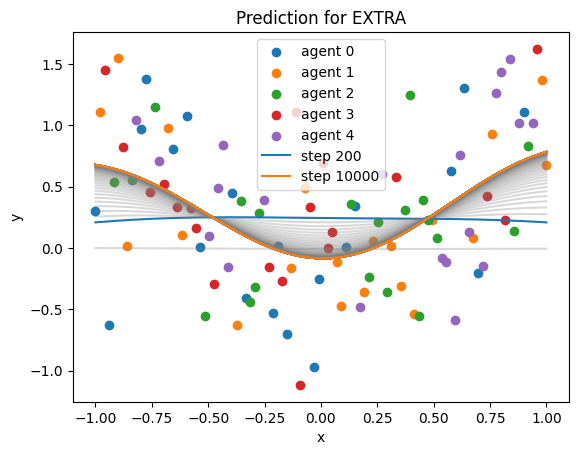

In [91]:
def plot(a, X, y, xi, algorithm):
    for i in range(a):
        plt.scatter(X[agents[i]], y[agents[i]], label=f"agent {i}")

    nt = 250
    x_linspace = np.linspace(-1, 1, nt)
    for s in range(0, 10000, 100):
        pred = [calc_f(X, ind, v, xi[s, 0, :]) for v in x_linspace]
        if s in [100, 9900]:  # 9900 corresponds to step 10000 if steps start from 0
            plt.plot(x_linspace, pred, label=f"step {s+100}")
        else:
            plt.plot(x_linspace, pred, color='gray', alpha=0.3)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Prediction for {algorithm}')
    plt.legend()
    plt.show()


plot(a, X,y, x_extra, 'EXTRA')
